In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import csv
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from skimage import io, transform
from skimage import color
import scipy.misc
import scipy.ndimage as ndi
from glob import glob
from pathlib import Path
from pytvision import visualization as view
from pytvision.transforms import transforms as mtrans
from tqdm import tqdm
sys.path.append('../')
from torchlib.datasets import dsxbdata
from torchlib.datasets.dsxbdata import DSXBExDataset, DSXBDataset
from torchlib.datasets import imageutl as imutl
from torchlib import utils
from torchlib.models import unetpad
from torchlib.metrics import get_metrics
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from pytvision.transforms import transforms as mtrans
from torchlib import metrics

from torchlib.segneuralnet import SegmentationNeuralNet
from torchlib import post_processing_func

In [2]:
map_post  = post_processing_func.MAP_post()
th_post   = post_processing_func.TH_post()
wts_post  = post_processing_func.WTS_post()

normalize = mtrans.ToMeanNormalization(
    mean = (0.485, 0.456, 0.406),  
    std  = (0.229, 0.224, 0.225), 
    )

class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean = (0.485, 0.456, 0.406), std  = (0.229, 0.224, 0.225)):
        mean     = torch.as_tensor(mean)
        std      = torch.as_tensor(std)
        std_inv  = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

n = NormalizeInverse()

def get_simple_transforms(pad=0):
    return transforms.Compose([
        #mtrans.CenterCrop( (1008, 1008) ),
        mtrans.ToPad( pad, pad, padding_mode=cv2.BORDER_CONSTANT ),
        mtrans.ToTensor(),
        normalize,      
    ])


def get_flip_transforms(pad=0):
    return transforms.Compose([
        #mtrans.CenterCrop( (1008, 1008) ),
        mtrans.ToRandomTransform( mtrans.VFlip(), prob=0.5 ),
        mtrans.ToRandomTransform( mtrans.HFlip(), prob=0.5 ),
        
        mtrans.ToPad( pad, pad, padding_mode=cv2.BORDER_CONSTANT ),
        mtrans.ToTensor(),
        normalize,      
    ])

def tensor2image(tensor, norm_inverse=True):
    if tensor.dim() == 4:
        tensor = tensor[0]
    if norm_inverse:
            tensor = n(tensor)
    img = tensor.cpu().numpy().transpose(1,2,0)
    img = (img * 255).clip(0, 255).astype(np.uint8)
    return img

def show(src, titles=[], suptitle="", 
         bwidth=4, bheight=4, save_file=False,
         show_axis=True, show_cbar=False, last_max=0):

    num_cols = len(src)
    
    plt.figure(figsize=(bwidth * num_cols, bheight))
    plt.suptitle(suptitle)

    for idx in range(num_cols):
        plt.subplot(1, num_cols, idx+1)
        if not show_axis: plt.axis("off")
        if idx < len(titles): plt.title(titles[idx])
        
        if idx == num_cols-1 and last_max:
            plt.imshow(src[idx]*1, vmax=last_max, vmin=0)
        else:
            plt.imshow(src[idx]*1)
        if type(show_cbar) is bool:
            if show_cbar: plt.colorbar()
        elif idx < len(show_cbar) and show_cbar[idx]:
            plt.colorbar()
        
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)
        
def show2(src, titles=[], suptitle="", 
         bwidth=4, bheight=4, save_file=False,
         show_axis=True, show_cbar=False, last_max=0):

    num_cols = len(src)//2
    
    plt.figure(figsize=(bwidth * num_cols, bheight*2))
    plt.suptitle(suptitle)

    for idx in range(num_cols*2):
        plt.subplot(2, num_cols, idx+1)
        if not show_axis: plt.axis("off")
        if idx < len(titles): plt.title(titles[idx])
        
        if idx == num_cols-1 and last_max:
            plt.imshow(src[idx]*1, vmax=last_max, vmin=0)
        else:
            plt.imshow(src[idx]*1)
        if type(show_cbar) is bool:
            if show_cbar: plt.colorbar()
        elif idx < len(show_cbar) and show_cbar[idx]:
            plt.colorbar()
        
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)
        
def get_diversity_map(preds, gt_predictionlb, th=0.5):
    max_iou = 0
    diversity_map = np.zeros_like(gt_predictionlb)
    for idx_gt in range(1, gt_predictionlb.max()):
        roi = (gt_predictionlb==idx_gt)
        max_iou = 0

        for predlb in preds:
            for idx_pred in range(1, predlb.max()):
                roi_pred  = (predlb==idx_pred)
                union = roi.astype(int) + roi_pred.astype(int)
                val, freq = np.unique(union, return_counts=True)

                if len(val)==3:
                    iou = freq[2]/(freq[1]+freq[2])
                    if iou > max_iou:
                        max_iou = iou
                if max_iou > th: break
            if max_iou >th:
                diversity_map += roi
    return diversity_map

In [27]:
glob('/home/chcp/Datasets/segprob*_0.0.0') 

['/home/chcp/Datasets/segprob21_0.0.0',
 '/home/chcp/Datasets/segprob1167_0.0.0',
 '/home/chcp/Datasets/segprob19_0.0.0']

['/home/chcp/Datasets/Seg1009_0.4.0/',
 '/home/chcp/Datasets/Seg33_0.0.0/',
 '/home/chcp/Datasets/Seg33_1.0.3/',
 '/home/chcp/Datasets/segprob21_0.0.0/',
 '/home/chcp/Datasets/segprob1167_0.0.0/',
 '/home/chcp/Datasets/Seg1009_0.3.2/',
 '/home/chcp/Datasets/Seg33_1.0.2/',
 '/home/chcp/Datasets/Seg1009_0.4.1/',
 '/home/chcp/Datasets/segprob19_0.0.0/',
 '/home/chcp/Datasets/Seg33_1.0.4/',
 '/home/chcp/Datasets/Seg33_1.0.1/']

In [62]:
all_segs = glob('/home/chcp/Datasets/[Ss]*_*.*.*[!)]/') 

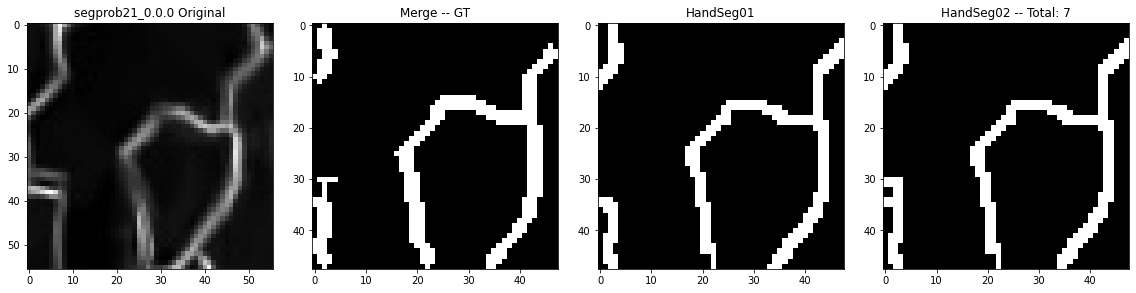

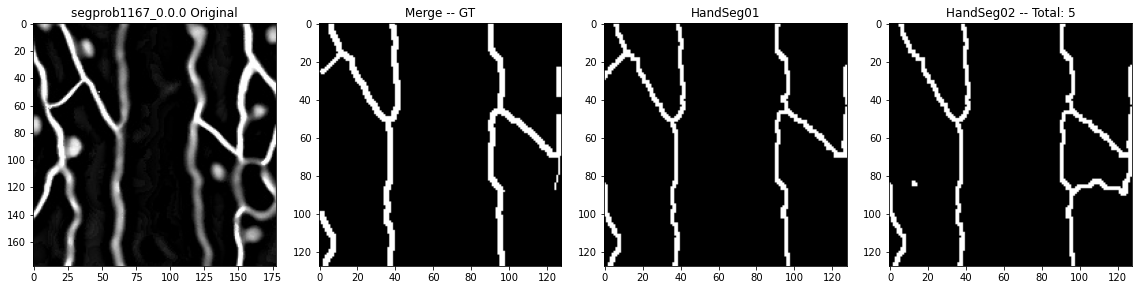

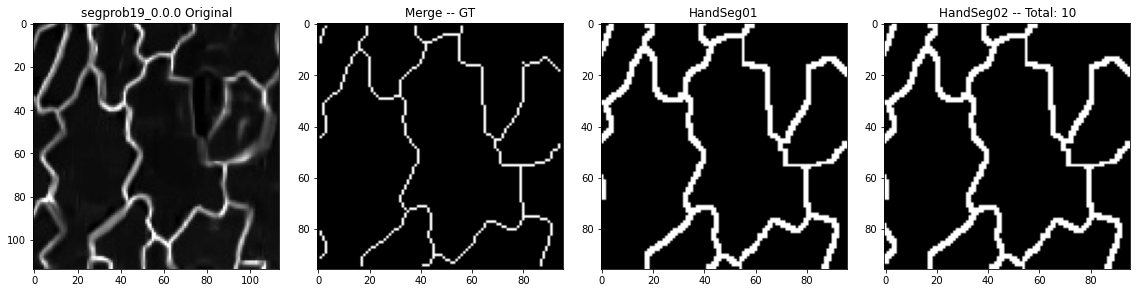

In [23]:
idx = 0
for dataset in glob('segprob*'):
    img_id = [Path(url).stem for url in glob(f'{dataset}/set/images/*.tif')][idx]
    src = cv2.imread(f'{dataset}/set/images/{img_id}.tif', -1)
    gt  = cv2.imread(f'{dataset}/set/labels2c/{img_id}.tif', -1) * 255
    samples = [cv2.imread(url) for url in glob(f'{dataset}/set/outputs/*/{img_id}.tif')]
    show([src, gt] + samples[:2], titles=[f"{dataset} Original", "Merge -- GT", "HandSeg01", f"HandSeg02 -- Total: {len(samples)}"])